Install Packages

In [1]:
pip install torch numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import defaultdict
from IPython.display import clear_output
import time

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GridWorld Environment - a simple 5x5 grid world, agent moves in 4 directions

In [4]:
class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.reset()

    def reset(self):
        self.pos = np.array([random.randint(0, self.size - 1), random.randint(0, self.size - 1)])
        return self._get_state()

    def step(self, action):
        move = [[0, 1], [0, -1], [-1, 0], [1, 0]]  # up, down, left, right
        self.pos += move[action]
        self.pos = np.clip(self.pos, 0, self.size - 1)
        return self._get_state()

    def _get_state(self):
        return self.pos.astype(np.float32) / (self.size - 1)


Random Network Distillation Network - a technique developed to encourage RL agents to explore their environments more effectively.

In [5]:
class RNDModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.target = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        self.predictor = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        # freeze target network
        for param in self.target.parameters():
            param.requires_grad = False

    def forward(self, x):
        with torch.no_grad():
            target_out = self.target(x)
        pred_out = self.predictor(x)
        return pred_out, target_out

Policy Network for Smarter Action Selection - [Policy Based Methods](https://huggingface.co/learn/deep-rl-course/unit4/what-are-policy-based-methods)

In [6]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, action_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.net(state)

Curiosity Agent - Agent Owen!

In [7]:
class CuriosityAgent:
    def __init__(self, state_size, action_size, lr=1e-3, penalty_weight=0.01):
        self.rnd = RNDModel(state_size).to(device)
        self.policy = PolicyNetwork(state_size, action_size).to(device)

        self.optimizer_rnd = optim.Adam(self.rnd.predictor.parameters(), lr=lr)
        self.optimizer_policy = optim.Adam(self.policy.parameters(), lr=lr)

        self.action_size = action_size
        self.visits = defaultdict(int)
        self.penalty_weight = penalty_weight

        # Memory for policy gradient
        self.log_probs = []
        self.rewards = []

    def get_state_key(self, state):
    # scale back to discrete grid coordinates
        return tuple((state * (env.size - 1)).astype(int))  # discretize

    def compute_intrinsic_reward(self, state):
        key = self.get_state_key(state)
        self.visits[key] += 1

        s = torch.tensor([state], dtype=torch.float32).to(device)
        pred, target = self.rnd(s)
        novelty = (pred - target).pow(2).mean().item()

        penalty = self.penalty_weight * self.visits[key]        # I should give it a name!!...
        return novelty - penalty

    def select_action(self, state):
        state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
        probs = self.policy(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        self.log_probs.append(log_prob)
        return action.item()

    def train_rnd(self, state):
        s = torch.tensor([state], dtype=torch.float32).to(device)     # how about Owen? I like it.
        pred, target = self.rnd(s)
        loss = (pred - target).pow(2).mean()

        self.optimizer_rnd.zero_grad()
        loss.backward()
        self.optimizer_rnd.step()
        return loss.item()

    def train_policy(self, gamma=0.99):
        G = 0
        returns = []

        # Compute discounted returns
        for r in reversed(self.rewards):
            G = r + gamma * G
            returns.insert(0, G)

        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        loss = 0
        for log_prob, R in zip(self.log_probs, returns):
            loss -= log_prob * R  # maximize expected reward

        self.optimizer_policy.zero_grad()
        loss.backward()
        self.optimizer_policy.step()

        self.log_probs = []
        self.rewards = []

Visualization

In [8]:
def render(env, agent, step):
    grid = np.zeros((env.size, env.size))

    for (x, y), count in agent.visits.items():
        grid[y, x] = count

    grid = np.log1p(grid)  # for better visualization

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(grid, cmap='Blues', origin='lower')
    pos = (int(env.pos[0]), int(env.pos[1]))
    ax.scatter(pos[1], pos[0], color='red', s=200, marker='o')
    ax.set_title(f"Step: {step} | Pos: {pos}")
    plt.grid(False)
    plt.show()

Training Loop with Live Visualization

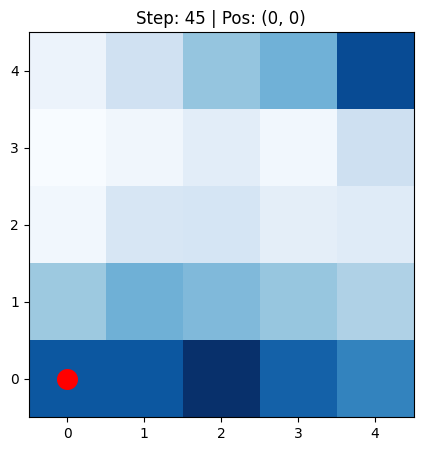

Episode 250, Total Intrinsic Reward: -264.4988
Episode 260, Total Intrinsic Reward: -279.5995
Episode 270, Total Intrinsic Reward: -263.8345
Episode 280, Total Intrinsic Reward: -314.2094
Episode 290, Total Intrinsic Reward: -276.7779


In [12]:
env = GridWorld(size=5)
agent = CuriosityAgent(state_size=2, action_size=4)

num_episodes = 300
episode_length = 50

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    for step in range(episode_length):
        action = agent.select_action(state) # but I'm so tired of wasting all this time, I need your love right now!
        next_state = env.step(action)

        reward = agent.compute_intrinsic_reward(next_state)     # Owen's just exploring his world, motivated by curiosity.
        agent.train_rnd(next_state)

        agent.rewards.append(reward)
        state = next_state
        total_reward += reward

        if episode % 50 == 0 and step % 5 == 0:
            clear_output(wait=True)
            render(env, agent, step)          # why's it always ending up at the same position? no, it's not.

    agent.train_policy()

    if episode % 10 == 0:
        print(f"Episode {episode}, Total Intrinsic Reward: {total_reward:.4f}")